In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stat

In [2]:
DAP_SPECIES = "PSIMIAE"
#DAP_SPECIES = "ECOLI"
FILTER_OUT_REDUNDANT = True
VALID_HITS_ONLY = True
MIN_MOTIF_SCORE = 0
MIN_peak_enrichment = 0

In [3]:
DATA_PATH    = F"/global/homes/v/vsevim/scratch/ML/grammar/data/{DAP_SPECIES}_RESULTS"
fimo_df_path = f"{DATA_PATH}/ALL_FIMO_HITS_ANNOTATED_W_PEAKS.pkl"

In [4]:
min_num_sites = 10
max_dist = 205

df_all_hits = pd.read_pickle(fimo_df_path)
df_all_hits['log10_peak_enrichment'] = np.log10(df_all_hits['peak_enrichment'].astype(float))
valid_filter        = (df_all_hits.target_is_ortho) & \
                      (df_all_hits.dist_to_pref_tgt <= max_dist)
redundant_filter    = (df_all_hits.redundant == False) 
has_a_target_filter = (df_all_hits.prefferred_target_loc != 'neither') #& (df_all_hits.score >= MIN_MOTIF_SCORE)


if FILTER_OUT_REDUNDANT:
    ortho_filter = valid_filter & redundant_filter
else:
    ortho_filter = valid_filter

if VALID_HITS_ONLY:    
    df_filtered_hits = df_all_hits[ortho_filter]
else:
    df_filtered_hits = df_all_hits[has_a_target_filter]

In [5]:
if VALID_HITS_ONLY:
    filter_criteria_msg = "valid hits"
else:
    filter_criteria_msg = "hits w/ targets"

if FILTER_OUT_REDUNDANT:
    filter_criteria_msg += ", redundants excluded"
else:
    filter_criteria_msg += ", redundants included"

In [6]:
df_filtered_hits.head(2)

chr   start     end  score strand  x  \
2   CP001978.1    6702    6722   46.3      -  .   
24  CP001978.1  574970  574995   96.6      +  .   

                                                 anno intergenic_chr  \
2   Name=Ps204_CP001978.1-;Alias=MEME-1;ID=Ps204-M...     CP001978.1   
24  Name=Ps453_CP001978.1+;Alias=MEME-1;ID=Ps453-M...     CP001978.1   

    intergenic_start  intergenic_end  ... peak_enrichment peak_start  \
2               6310            6909  ...        35.88456       6693   
24            574336          575041  ...       831.32166     574964   

    peak_end  indexcol redundant midpoint length prefferred_target_loc  \
2       6753         2     False     6712     20            downstream   
24    575024        24     False   574983     25            downstream   

    dist_to_pref_tgt  log10_peak_enrichment  
2                197               1.554908  
24                58               2.919769  

[2 rows x 40 columns]

In [7]:
df_filtered_hits.columns

Index(['chr', 'start', 'end', 'score', 'strand', 'x', 'anno', 'intergenic_chr',
       'intergenic_start', 'intergenic_end', 'intergenic_label', 'u_type',
       'u_start', 'u_end', 'u_ori', 'u_accession', 'u_name', 'dw_type',
       'd_start', 'd_end', 'd_ori', 'd_accession', 'd_name', 'tf_id',
       'species', 'target_location', 'u_is_ortho', 'd_is_ortho',
       'target_is_ortho', 'peak_id', 'peak_enrichment', 'peak_start',
       'peak_end', 'indexcol', 'redundant', 'midpoint', 'length',
       'prefferred_target_loc', 'dist_to_pref_tgt', 'log10_peak_enrichment'],
      dtype='object')

# Create peak stats df

In [8]:
df_groups  = df_filtered_hits.groupby(['tf_id','intergenic_label','peak_id'])
hit_counts = [len(df_group) for group_name, df_group in df_groups]
peak_stuff = [
                [
                    str(group_name[0]),
                    group_name[2],
                    df_group['peak_enrichment'].astype(float).values[0],
                    len(df_group),
                    df_group['length'].values[0],
                    df_group['dist_to_pref_tgt'].mean()
                ]
                    for group_name, df_group in df_groups
            ]

col_names = ['tf_id', 'peak_id', 'peak_enrichment', 'hit_count', 'motif_length', 'dist_to_pref_tgt']
df_peak_stats = pd.DataFrame(peak_stuff, columns=col_names)
df_peak_stats['log10_peak_enrichment'] = np.log10(df_peak_stats['peak_enrichment'])

In [9]:
num_filtered_peaks = len(df_peak_stats)
num_peaks_w_target = len(df_all_hits['peak_id'].unique())
print(num_filtered_peaks, f"filtered peaks in {DAP_SPECIES} set")
print(num_peaks_w_target, f"total peaks in {DAP_SPECIES} set")

1716 filtered peaks in PSIMIAE set
9758 total peaks in PSIMIAE set


In [10]:
df_peak_stats.head(3)

tf_id                          peak_id  peak_enrichment  hit_count  \
0     4  4_D-TGAGGATG+GATTGCAC_peak_1101       2593.47852          2   
1     4   4_D-TGAGGATG+TTGTGCAG_peak_79a        211.31375          1   
2     4    4_D-TGAGGATG+TTGTGCAG_peak_91        197.09810          1   

   motif_length  dist_to_pref_tgt  log10_peak_enrichment  
0            19              28.5               3.413883  
1            19              30.0               2.324928  
2            19              39.0               2.294682

## Debug

In [11]:
df_filtered_hits['dist_to_pref_tgt'].mean()
#df_filtered_hits.columns

68.4317673378076

In [12]:
select_neither = df_filtered_hits['prefferred_target_loc'] == 'neither'
len(df_filtered_hits) - len(df_filtered_hits[select_neither])

2682

# Define interval func

In [13]:
# This function returns the intervals between consecutive motifs
# on a given strand.

def get_intervals(df, peak_id, strand):    
    all_intervals = []
    filter_exp = (df['peak_id'] == peak_id) & (df['strand'] == strand)
    df_selected = df[filter_exp]

    #print(df_selected)
    intervals = np.NAN
    if (len(df_selected) > 1):
        # There is more than one hit under the peak
        intervals = df_selected['start'].diff().dropna().astype(int).tolist()
        uniq_intervals = set(intervals)
    else:
        # There is only one site
        intervals = []
            
    all_intervals += intervals
    
#    if len(all_intervals) == 1:
#        return all_intervals[0]

    if len(all_intervals) > 0:    
        return all_intervals
    else:
        return []

In [14]:
def get_intervals_on_both_strands(df, peak_id):
    dist_sense     = get_intervals(df, peak_id, "+")
    dist_antisense = get_intervals(df, peak_id, "-")
    #if (len(dist_sense) > 0) or (len(dist_antisense)>0):  
    return [dist_sense, dist_antisense]

## Debug

In [15]:
#get_intervals(df_filtered_hits, "4_D-TGAGGATG+GATTGCAC_peak_1101", "+")
#get_intervals(df_filtered_hits, "4_D-TGAGGATG+TTGTGCAG_peak_79a", "+")

peak_id = "4_D-TGAGGATG+AGCAGTAG_peak_3015"
filter_peak = df_filtered_hits['peak_id'] == "4_D-TGAGGATG+AGCAGTAG_peak_3015"
[dist_sense, dist_antisense] = get_intervals_on_both_strands(df_filtered_hits, peak_id)
#df_filtered_hits[filter_peak][['chr', 'u_accession', 'd_accession', 'length']]

# Get inter-motif intervals into the df

Get sense and antisense intervals seperately, then combine them

In [16]:
intervals_between_hits_sense     = [get_intervals(df_filtered_hits, peak_id, "+") for peak_id in df_peak_stats['peak_id']]
intervals_between_hits_antisense = [get_intervals(df_filtered_hits, peak_id, "-") for peak_id in df_peak_stats['peak_id']]
assert len(intervals_between_hits_antisense) == len(intervals_between_hits_sense)
dummy = [list(set(pair[0]+pair[1])) for pair in zip(intervals_between_hits_antisense, intervals_between_hits_sense)]

In [17]:
# replace empty arrays with nan
intervals_combined = [np.NAN if len(d)==0 
                      else d[0] if len(d)==1
                      else d
                      for d in dummy]

# If there is only a single interval value under the peak, then I consider the interval regular
is_regular = [True if type(d) is int else False for d in intervals_combined]

Put them into the df

In [18]:
df_peak_stats['sense_intervals_uniq']     = intervals_between_hits_sense
df_peak_stats['antisense_intervals_uniq'] = intervals_between_hits_antisense
df_peak_stats['both_intervals_uniq']      = intervals_combined
df_peak_stats['regular_interval']   = is_regular

In [19]:
df_peak_stats[df_peak_stats['hit_count']>2].head(8)

tf_id                           peak_id  peak_enrichment  hit_count  \
32      4   4_D-TGAGGATG+AGCAGTAG_peak_3015        650.89441          4   
36      4   4_D-TGAGGATG+TTGAAGCC_peak_4970        366.84796          4   
173    34  34_D-TTTTGGGG+TTGTGCAG_peak_3257         18.64215          3   
177    39  39_D-CAGTTGCA+TTGTGCAG_peak_2503        450.66330          3   
215    48   48_D-GCTGGAAA+TTATGGGC_peak_725         19.18904          3   
216    48  48_D-GCTGGAAA+AGCAGTAG_peak_3475         14.79434          3   
277    61  61_D-ATGCGTCA+GTGAGATG_peak_2055        342.73557          3   
399   101  101_D-TGGTGACT+ACTACGCA_peak_483        405.35336          4   

     motif_length  dist_to_pref_tgt  log10_peak_enrichment  \
32             19         18.500000               2.813511   
36             19         18.500000               2.564486   
173            20         82.666667               1.270496   
177            14        156.333333               2.653852   
215            14         16.333333               1.283053   
216            14         18.333333               1.170096   
277            20         26.666667               2.534959   
399            31         89.750000               2.607834   

    sense_intervals_uniq antisense_intervals_uniq both_intervals_uniq  \
32                  [26]                     [26]                  26   
36                  [26]                     [26]                  26   
173                 [23]                       []                  23   
177                   []                     [11]                  11   
215                   []                      [8]                   8   
216                  [8]                       []                   8   
277              [9, 22]                       []             [9, 22]   
399              [7, 13]                       []             [13, 7]   

     regular_interval  
32               True  
36               True  
173              True  
177              True  
215              True  
216              True  
277             False  
399             False

# Stats

In [20]:
num_valid_hits = len(df_filtered_hits)
num_all_hits   = len(df_all_hits)
percentage_valid = 100.*num_valid_hits/num_all_hits
print("{}: {} valid hits out of {} found. %{:.1f} of total.".format(DAP_SPECIES, num_valid_hits, num_all_hits,percentage_valid))

PSIMIAE: 2682 valid hits out of 16046 found. %16.7 of total.


In [21]:
select_const = df_peak_stats['regular_interval']
df_peak_stats_regulars = df_peak_stats[select_const]
num_peaks_w_regular_dist = len(df_peak_stats_regulars)
print(f"{DAP_SPECIES}: there are {num_peaks_w_regular_dist} peaks with regular motif interval")

PSIMIAE: there are 292 peaks with regular motif interval


Text(0.5, 1.0, 'PSIMIAE motif scores\n(valid hits, redundants excluded)')

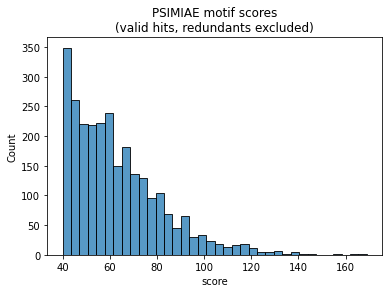

In [22]:
cat_plot = sns.histplot(x='score', data=df_filtered_hits)
cat_plot.set_title(f"{DAP_SPECIES} motif scores\n({filter_criteria_msg})")
#cat_plot.set(yscale="log")

Text(0.5, 1.0, 'PSIMIAE motif scores\n(all hits)')

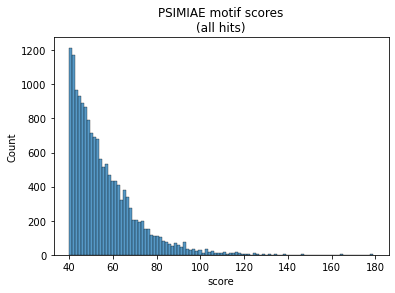

In [23]:
cat_plot = sns.histplot(x='score', data=df_all_hits)
cat_plot.set_title(f"{DAP_SPECIES} motif scores\n(all hits)")

[Text(0.5, 0, 'log10 peak enrichment')]

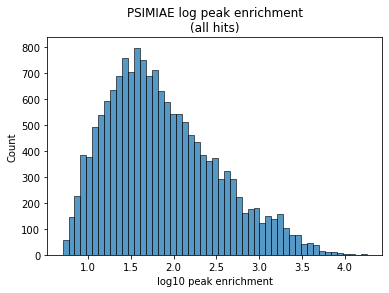

In [24]:
cat_plot = sns.histplot(x='log10_peak_enrichment', data=df_all_hits)
cat_plot.set_title(f"{DAP_SPECIES} log peak enrichment\n(all hits)")
cat_plot.set(xlabel="log10 peak enrichment")

In [25]:
df_all_hits.peak_enrichment.values

array([29.81436, 25.91318, 35.88456, ..., 10.01228, 16.70086, 16.70086])

Text(0.5, 1.0, 'PSIMIAE distance to target\nvalid hits, redundants excluded')

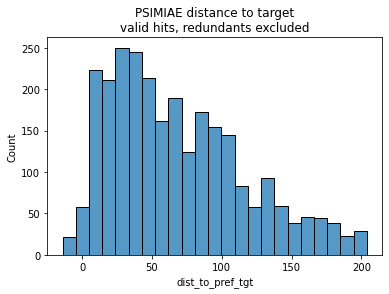

In [26]:
cat_plot = sns.histplot(x='dist_to_pref_tgt', data=df_filtered_hits)
cat_plot.set_title(f"{DAP_SPECIES} distance to target\n{filter_criteria_msg}")

[Text(0, 0.5, 'log peak enrichment')]

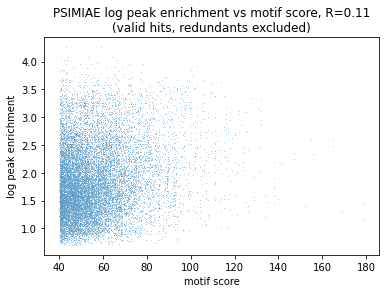

In [27]:
df = df_all_hits
x = df['score']
y = df['peak_enrichment']
R,p = stat.pearsonr(x, y)

plot = sns.scatterplot(y='log10_peak_enrichment', x='score', data=df, s=.5)
plot.set_title(f"{DAP_SPECIES} log peak enrichment vs motif score, R={R:.2}\n({filter_criteria_msg})")
plot.set(xlabel="motif score")
plot.set(ylabel="log peak enrichment")

[(0.0, 300.0)]

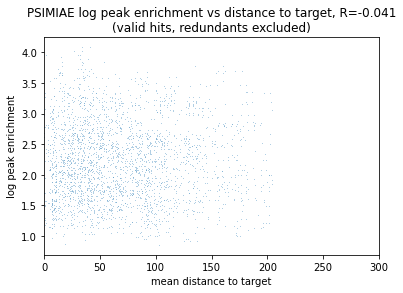

In [28]:
df = df_filtered_hits
x = df['dist_to_pref_tgt']
y = df['peak_enrichment']
R,p = stat.pearsonr(x, y)

plot = sns.scatterplot(y='log10_peak_enrichment', x='dist_to_pref_tgt', data=df, s=.5)
plot.set_title(f"{DAP_SPECIES} log peak enrichment vs distance to target, R={R:.2}\n({filter_criteria_msg})")
plot.set(xlabel="mean distance to target")
plot.set(ylabel="log peak enrichment")
plot.set(xlim=(0,300))

Text(0.5, 1.0, 'PSIMIAE motif hits per DAP peak\n(valid hits, redundants excluded)')

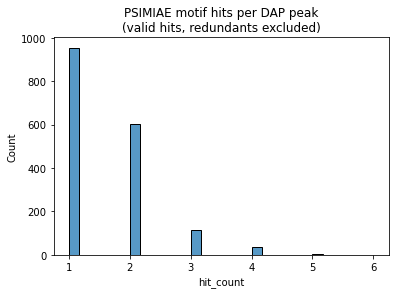

In [29]:
cat_plot = sns.histplot(x='hit_count', data=df_peak_stats, shrink=1)
cat_plot.set_title(f"{DAP_SPECIES} motif hits per DAP peak\n({filter_criteria_msg})")

Text(0.5, 1.0, 'PSIMIAE motif lengths\n(valid hits, redundants excluded)')

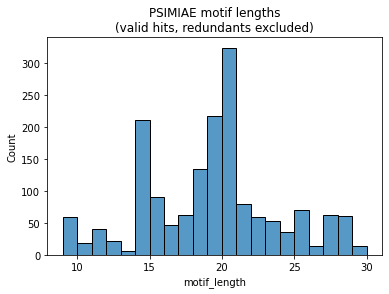

In [30]:
motif_lengths = df_peak_stats['motif_length'].unique()
min_bin = min(motif_lengths)
max_bin = max(motif_lengths)
bin_range = range(min_bin, max_bin)

cat_plot = sns.histplot(x='motif_length', data=df_peak_stats, bins=bin_range)
cat_plot.set_title(f"{DAP_SPECIES} motif lengths\n({filter_criteria_msg})")

[Text(0.5, 0, 'interval')]

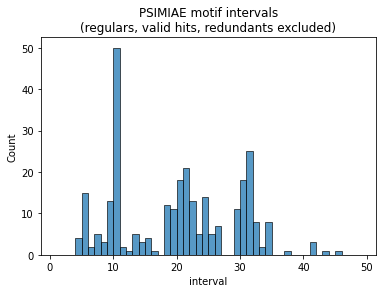

In [31]:
cat_plot = sns.histplot(x='both_intervals_uniq', data=df_peak_stats_regulars, bins=range(1,50))
cat_plot.set_title(f"{DAP_SPECIES} motif intervals\n(regulars, {filter_criteria_msg})")
cat_plot.set(xlabel="interval")

Text(0.5, 1.0, 'PSIMIAE log peak enrichment vs motif hits under peak\n(valid hits, redundants excluded)')

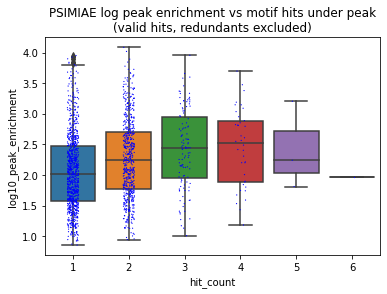

In [32]:
#cat_plot = sns.catplot(x='hit_count', y='peak_enrichment', kind='box', data=df_peak_stats)
#cat_plot.fig.suptitle(f"{DAP_SPECIES} log peak score vs motif hits under peak\n({filter_criteria_msg})")

cat_plot = sns.boxplot(x='hit_count', y='log10_peak_enrichment', data=df_peak_stats)
cat_plot = sns.stripplot(x='hit_count', y='log10_peak_enrichment', data=df_peak_stats, color="blue", size=1.2)
cat_plot.set_title(f"{DAP_SPECIES} log peak enrichment vs motif hits under peak\n({filter_criteria_msg})")
#cat_plot.set(yscale="log")
#cat_plot.set(yscale="log")

Text(0.5, 1.0, 'PSIMIAE log peak enrichment vs motif hits under peak\n(regular intervals only,valid hits, redundants excluded)')

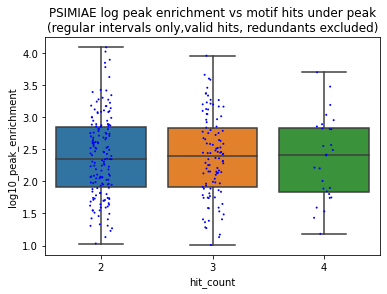

In [33]:
cat_plot = sns.boxplot(x='hit_count', y='log10_peak_enrichment', data=df_peak_stats_regulars)
cat_plot = sns.stripplot(x='hit_count', y='log10_peak_enrichment', data=df_peak_stats_regulars, color="blue", size=2)
cat_plot.set_title(f"{DAP_SPECIES} log peak enrichment vs motif hits under peak\n(regular intervals only,{filter_criteria_msg})")
#cat_plot.set(yscale="log")

Text(0.5, 0.98, 'PSIMIAE log peak enrichment vs motif length\n(valid hits, redundants excluded)')

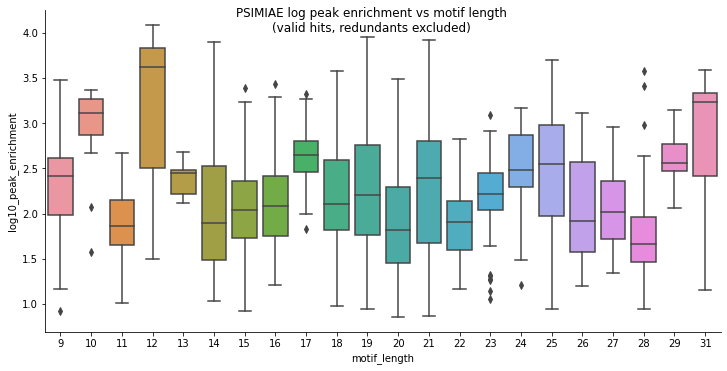

In [34]:
cat_plot = sns.catplot(x='motif_length', y='log10_peak_enrichment', kind='box', data=df_peak_stats, height=5, aspect=2)
cat_plot.fig.suptitle(f"{DAP_SPECIES} log peak enrichment vs motif length\n({filter_criteria_msg})")
#cat_plot.set(yscale="log")

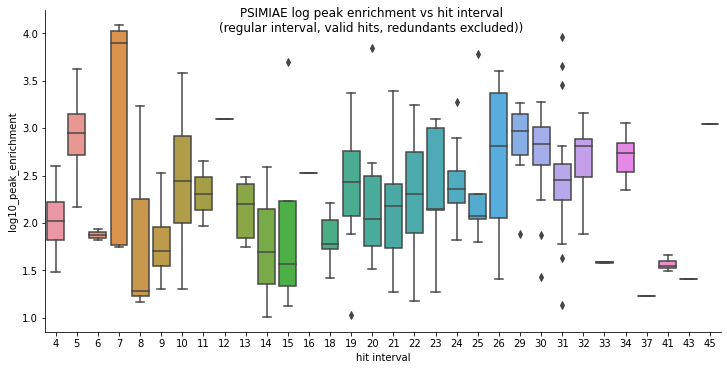

In [35]:
cat_plot = sns.catplot(x='both_intervals_uniq', y='log10_peak_enrichment', kind='box', data=df_peak_stats_regulars, height=5, aspect=2)
cat_plot.fig.suptitle(f"{DAP_SPECIES} log peak enrichment vs hit interval\n(regular interval, {filter_criteria_msg}))")
cat_plot.set(xlabel="hit interval")
#cat_plot.set(ylabel="log10_ peak enrichment")

In [36]:
len(df_peak_stats_regulars)

292

# Plot scores for individual TFs 

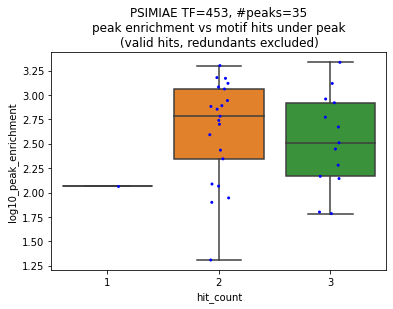

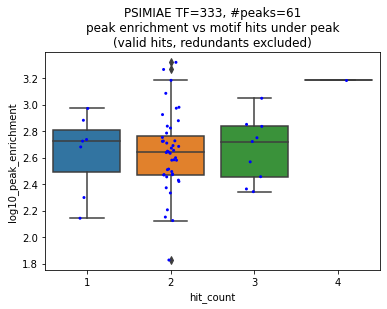

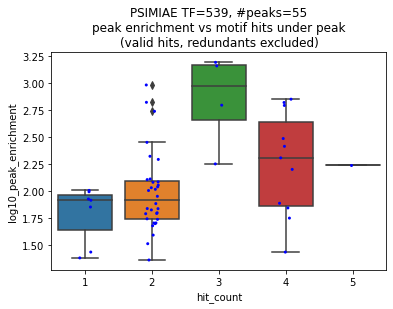

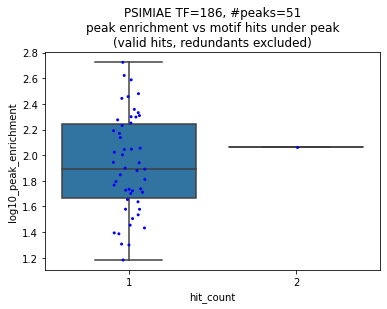

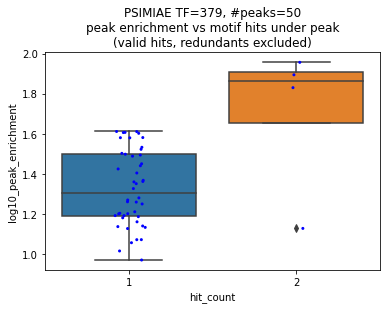

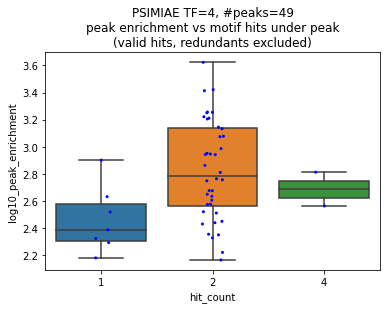

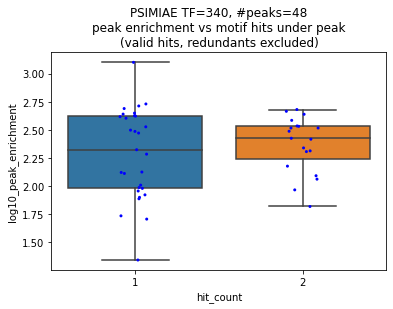

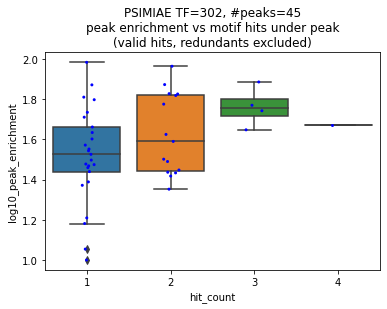

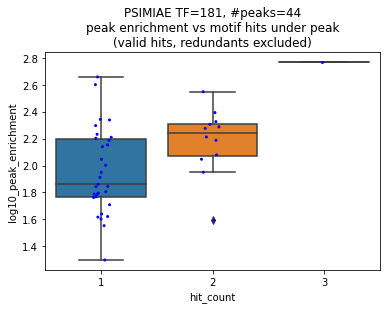

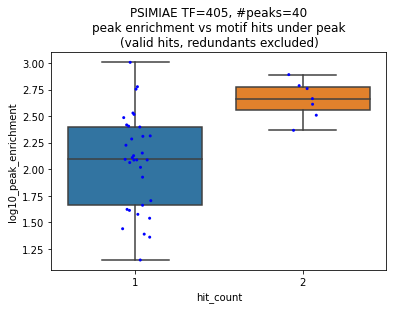

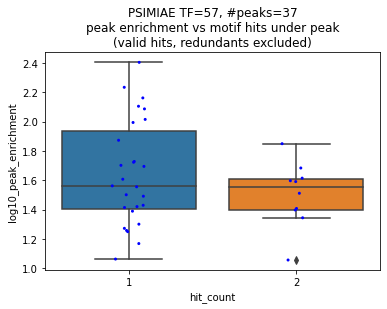

In [37]:
if DAP_SPECIES == "PSIMIAE":
    tf_ids = ['453', '333', '539', '186', '379', '4', '340', '302', '181', '405', '57']
else:
    tf_ids = ["mraZ", 'lexA', 'pdhR', 'metJ', 'slyA', 'ompR', 'oxyR', 'yhaJ', 'fadR', 'dnaA', 'yebK']
    
for tf_id in tf_ids: 
    select_tf = (df_peak_stats['tf_id'] == tf_id) 
    dummy_df  = df_peak_stats[select_tf]
    n_peaks = len(dummy_df)

    cat_plot = sns.boxplot(x='hit_count', y='log10_peak_enrichment', data=dummy_df)
    cat_plot = sns.stripplot(x='hit_count', y='log10_peak_enrichment', data=dummy_df, color="blue", size=3.)
    cat_plot.set_title(f"{DAP_SPECIES} TF={tf_id}, #peaks={n_peaks}\npeak enrichment vs motif hits under peak\n({filter_criteria_msg})")
    plt.show()

## Debug

In [38]:
df_peak_stats['tf_id'].value_counts().head(10).index

Index(['333', '539', '186', '379', '4', '340', '302', '181', '405', '57'], dtype='object')

In [39]:
select_tf = df_all_hits['tf_id'] == 453
len(df_all_hits[select_tf]['peak_id'].unique())

38